# Optimization with Cython -- Indian Buffet Process (IBP)

### Optimization
Completed:
- Only calculate $M$ right before any likelihood calculation (i.e. reduce the number of calculations)

What to do next:
- Need to get the code correct! (I will try my best, but I will receive partial credit even if I cannot figure out.)
- Try to figure out: Effective inverse calculation from Griffiths and Ghahramani (2005; Equations 51 to 54)
- Cythonize the code (now working)

### Cython

"Cython is allows you to write normal Python code and then add type annotations. This code is first translated to C code, which is in turn compiled to machine code. In effect, if you do it right, your code will become as fast as C. The downside is that you need a C compiler on your machine." http://www.pyzo.org/speed.html

- Note: Cython cannot use libraries and variables from multiple cells.
- Recommendation: Cythonize functions only!

### Simple Cython Example

In [18]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [19]:
%%cython -a
def cy_fib(n):
    a = 0
    b = 1
    for i in range(n):
        a, b = a+b, a
    return a

In [20]:
cy_fib(10)

55

### My Code Starts Here

### Indian Buffet Process (IBP): Steps

- Step 1: First customer takes a Poisson($\alpha$) of dishes
- Step 2: The $i$th customer takes dish $k$ with probability $\frac{m_k}{i}$, where $m_k$ is the number of previous customers who sampled that dish
- Step 3: The $i$th customer tries a Poisson($\frac{\alpha}{i}$) number of new dishes
- Storage: Binary matrix $\mathbf{Z}$ with $N$ rows and infinite columns, where $z_{ik}$ = 1 if customer $i$ sampled the dish $k$
- Probability: $P(z_{ik}=1 | \mathbf{z_{-i,k}}) = \dfrac{m_{-i,k}+\dfrac{\alpha}{K}}{N+\dfrac{\alpha}{K}} \rightarrow \dfrac{m_{-i,k}}{N}$ as $K \rightarrow \infty$

Special note: This is JUST a prior, not something you put in the Gibbs sampler!

In [21]:
%%cython -a
import numpy as np

def calcM(Z,Kplus,sigmaX,sigmaA):
    """Save the matrix M so we won't need to calculate it again and again"""
    return np.linalg.inv(np.dot(Z[:,0:Kplus].T,Z[:,0:Kplus])+((sigmaX/sigmaA)**2)*np.identity(Kplus))

def calcInverse_orig(Z, M, i, k, val):
    """Effective inverse calculation from Griffiths and Ghahramani (2005; Equations 51 to 54)
    M_(-i) = inv(inv(M) - zi.T * zi)"""
    M_i = M - np.dot(np.dot(M,Z[i,:].T),np.dot(Z[i,:],M))/(np.dot(np.dot(Z[i,:],M),Z[i,:].T)-1)
    Z[i,k] = val
    M = M_i - np.dot(np.dot(M_i,Z[i,:].T),np.dot(Z[i,:],M_i))/(np.dot(np.dot(Z[i,:],M_i),Z[i,:].T)+1)
    Inv = M
    return Inv

def calcInverse(Z, M, i, k, val):
    """New version to check: M_(-i) = inv(inv(M) - zi.T * zi)"""
    Z[i,k] = val
    return np.linalg.inv(np.linalg.inv(M) - np.dot(Z[i,:].T,Z[i,:]))

def log_likelihood(X,Z,M,sigmaA,sigmaX,Kplus,N,D):  
    """Calculate the log-likelihood: P(X|Z,M,sigmaA,sigmaX,Kplus,N,D)"""  
    determinant = np.linalg.det(np.dot(Z.T,Z)+((sigmaX/sigmaA)**2)*np.identity(Kplus))
    constant = N*D*0.5*np.log(2*np.pi) + (N-Kplus)*D*np.log(sigmaX) + Kplus*D*np.log(sigmaA) + D*0.5*np.log(determinant)
    
    middle = np.identity(N) - np.dot(np.dot(Z, M),Z.T)
    trace = np.trace(np.dot(np.dot(X.T,middle),X))
    kernel = -0.5*np.reciprocal(sigmaX**2)*trace
    
    log_lik = -constant + kernel
    return log_lik

In [28]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# %matplotlib inline
# %precision 4
plt.style.use('ggplot')

np.random.seed(1234)
import scipy.stats as stats
import timeit

def IBP(N, alpha):
    """Indian Buffet Process (IBP) steps:
    Input: N is the number of customers (objects, images); alpha is the only parameter;
    Return: result is the binary matrix (prior); Kplus is the number of dishes (features)"""
    result = np.zeros((N,1000))
    
    # Step 1: First customer takes a Poisson(alpha) of dishes
    t = stats.poisson.rvs(alpha) # (set the random seed when calling the function)
    if t > 0:
        result[0,0:t] = 1
    
    # Kplus = the number of features for which m_k > 0 (m_k: the number of previous customers who sampled that dish)
    Kplus = t
    for i in range(1,N):
        for k in range(Kplus):
            # Step 2: The ith customer takes dish k with probability m_k/i
            p = np.sum(result[0:(i+1),k])/(i+1) # this is a probability, so should be between 0 and 1
            assert p <= 1 
            assert p >= 0
            if stats.uniform.rvs(0) < p:
                result[i,k] = 1
            else:
                result[i,k] = 0
                
        # Step 3: The ith customer tries a Poisson(alpha/i) number of new dishes
        t = stats.poisson.rvs(alpha/(i+1))
        if t > 0:
            result[i,Kplus:(Kplus+t)] = 1
        Kplus += t
    result = result[:,0:Kplus]
    
    return result, Kplus

# --------------------------------------------------------------------------------------------------

# Basis images
import Image
basis1 = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,1,0,0,0,0],[1,1,1,0,0,0],[0,1,0,0,0,0]])
basis2 = np.array([[1,1,1,0,0,0],[1,0,1,0,0,0],[1,1,1,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
basis3 = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,1],[0,0,0,0,1,1],[0,0,0,1,1,1]])
basis4 = np.array([[0,0,0,1,0,0],[0,0,0,1,1,1],[0,0,0,1,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])

D = 36
b1 = basis1.reshape(D)
b2 = basis2.reshape(D)
b3 = basis3.reshape(D)
b4 = basis4.reshape(D)
A = np.array([b1,b2,b3,b4])

# Generate image data: 100 matrices of size 6*6
N = 100
D = 36
K = 4
sigmaX_orig = 0.5

# All K basis images, each of length D
# Generate N images (customers, objects)
np.random.seed(1234)
images = np.zeros((N,6,6)) # simulated image data
structure = np.zeros((N,6,6))  # 0/1 structure for each image
add = stats.bernoulli.rvs(0.5,size=(N,K)) # whether the K=4 latent bases are present in each image
epsilon = stats.norm.rvs(loc=0,scale=0.5,size = (N,6,6)) # random noise

for i in range(N):
    structure[i,:,:] = add[i,0]*basis1 + add[i,1]*basis2 + add[i,2]*basis3 + add[i,3]*basis4
    images[i,:,:] = structure[i,:,:] + epsilon[i,:,:]

Z_orig = add    

# Generate the Harmonic numbers, but we only need the sum
from fractions import Fraction
sum_Harmonics = 0
Harmonics = 0
for i in range(N):
    sum_Harmonics += (N-i)*Fraction(1,i+1)
    Harmonics += Fraction(1,i+1)
# print "Sum of H_1 + ... + H_N:", float(sum_Harmonics)
# print "Harmonic number H_N:", float(Harmonics)

# -------------------------------------------------------------------------------------------------------

# Initialization
N = 100
D = 36
K = 4
sigmaA = 1
sigmaX = 1

np.random.seed(1005)
# alpha = stats.gamma.rvs(a = 1, loc = 0, scale = 1, size = 1)[0]
alpha = 1

K_inf = 1000
Z, Kplus = IBP(N, alpha)
print "Initial Kplus:", Kplus
print "Z.shape:",Z.shape # (100,4) = (N,Kplus) (latent)
print "A.shape:",A.shape # (4,36) = (Kplus,D)  (weight)

# Set MCMC steps
mcmc = 1000 # plan to sample for 1000 times

# Setup the array
Z_arr = np.zeros((mcmc,N,K_inf))
Kplus_arr = np.zeros(mcmc)
sigmaX_arr = np.zeros(mcmc)
sigmaA_arr = np.zeros(mcmc)
alpha_arr = np.zeros(mcmc)
rX_accept = 0
rA_accept = 0

# More initialization
np.random.seed(16)
basis1 = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,1,0,0,0,0],[1,1,1,0,0,0],[0,1,0,0,0,0]])
basis2 = np.array([[1,1,1,0,0,0],[1,0,1,0,0,0],[1,1,1,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
basis3 = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,1],[0,0,0,0,1,1],[0,0,0,1,1,1]])
basis4 = np.array([[0,0,0,1,0,0],[0,0,0,1,1,1],[0,0,0,1,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])

D = 36
b1 = basis1.reshape(D)
b2 = basis2.reshape(D)
b3 = basis3.reshape(D)
b4 = basis4.reshape(D)
A = np.array([b1,b2,b3,b4])

Z_orig = np.zeros((N,4))
sigmaX_orig = 0.5
X = np.zeros((N,D))

for i in range(N):
    Z_orig[i,:] = stats.uniform.rvs(loc=0,scale=1,size=4) > 0.5
    while np.sum(Z_orig[i,:]) == 0:
        Z_orig[i,:] = stats.uniform.rvs(loc=0,scale=1,size=4) > 0.5
    X[i,:] = np.random.normal(size=D)*sigmaX_orig + np.dot(Z_orig[i,:],A)
    


# -----------------------------------------------------------------------------------------------------------------------------

# Gibbs Sampler -- Steps
np.random.seed(111)
elapsed = 0
elapsed1 = 0
elapsed2 = 0
elapsed1k_count = 0
elapsed1N_count = 0
elapsed1k_init = 0
elapsed1k_calc = 0

start = timeit.default_timer()

# for mc in range(mcmc):
# for mc in range(1000):
for mc in range(1000): # just test for 10 iterations

    # Step 0: Save generated parameters to the MCMC array
    Z_arr[mc,:,0:Kplus] = Z[:,0:Kplus]
    # print "Shape of Z:",Z.shape
    
    alpha_arr[mc] = alpha
    Kplus_arr[mc] = Kplus
    sigmaX_arr[mc] = sigmaX
    sigmaA_arr[mc] = sigmaA
    
    print "At iteration",mc,": Kplus is",Kplus,", alpha is",alpha
    # print "Generating Z|alpha takes",elapsed1,"sec, and sampling sigmaX, sigmaA takes",elapsed2,"sec"
    # print "In generating Z|alpha, sampling from Kplus takes",elapsed1k_count/N,"sec, and sampling new dishes takes",elapsed1N_count/N,"sec"ㄊ
    # print "In generating Z|alpha -- sampling from Kplus, initializing takes",elapsed1k_init,"sec; calculation takes",elapsed1k_calc,"sec"
    # print "----------------------------------------------------"
    
    # Step 1: Generate Z|alpha (Gibbs)
    start1 = timeit.default_timer()
    elapsed1k_count = 0
    elapsed1N_count = 0
    
    for i in range(N):
        # Save the matrix M so we won't need to calculate it again and again
        #M = calcM(Z,Kplus,sigmaX,sigmaA)
        
        start1k = timeit.default_timer()
        
        for k in range(Kplus):
            
            start1k_init = timeit.default_timer()
            
            # This is possible because Kplus may decrease in this loop (e.g. dropping redundant zeros)
            if (k+1) > Kplus:
                break
            if Z[i,k] > 0:
                # Take care of singular features
                # Get rid of the features not sampled (remove the zeros)
                if np.sum(Z[:,k]) - Z[i,k] <= 0: # whether the dish is sampled by other customers or not
                # if np.sum(Z[:,k]) - Z[i,k] == 0: # same as the code above since Z is binary
                    #Z[i,k] = 0
                    # Avoid Kplus to become zero!
#                     if Kplus == 1:
#                         Z[:,0] = Z[:,1]
#                     else: # Kplus > 1
                    Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus]
                    Kplus -= 1
                        # Z = Z[:,0:Kplus] # remove the last column
                    #M = calcM(Z,Kplus,sigmaX,sigmaA)          
                    continue            
            
            elapsed1k_init = timeit.default_timer() - start1k_init
            
            start1k_calc = timeit.default_timer()
            
            # Effective inverse calculation from Griffiths and Ghahramani (2005; Equations 51 to 54)
            # M_(-i) = inv(inv(M) - zi.T * zi)
#             M0 = calcInverse(Z[:,0:Kplus], M, i, k, 0)
#             M1 = calcInverse(Z[:,0:Kplus], M, i, k, 1)
            
            # Then calculate the posterior distribution: prior * likelihood 
            # i.e. customers sample the dishes that have been previously sampled
            # Likelihood: P(X|Z_(-i,k),sigmaX,sigmaA)
            # Prior: P(z_ik = 1 | z_(-i,k)) = m_(-i,k) / N, where m_(-i,k) = number of objects possess feature k, excluding i
            P = np.zeros(2)
            Z[i,k] = 1
            M1 = calcM(Z,Kplus,sigmaX,sigmaA) 
            P[1] = log_likelihood(X,Z[:,0:Kplus],M1,sigmaA,sigmaX,Kplus,N,D) + np.log(sum(Z[:,k])-Z[i,k]) - np.log(N)
            Z[i,k] = 0
            M0 = calcM(Z,Kplus,sigmaX,sigmaA) 
            P[0] = log_likelihood(X,Z[:,0:Kplus],M0,sigmaA,sigmaX,Kplus,N,D) + np.log(N-sum(Z[:,k])) - np.log(N)
            P = np.exp(P - max(P))
            # Sample from the posterior distribution
            rand = stats.uniform.rvs(loc=0,scale=1,size=1)           
            if rand < P[0]/(P[0]+P[1]):
                Z[i,k] = 0
                #M = M0
            else:
                Z[i,k] = 1
                #M = M1

            elapsed1k_calc = timeit.default_timer() - start1k_calc
        elapsed1k = timeit.default_timer() - start1k
        elapsed1k_count += elapsed1k
        
        # Sample the number of new dishes Pois(alpha/i) for the current customer/object
        # Truncated prior: P(z_ik = 1 | z_(-i,k)) = (m_(-i,k) + alpha/Kplus) / (N + alpha/Kplus)
        
        start1N = timeit.default_timer()
        
        # trun = np.zeros(5)
        trun = np.zeros(4)
        # alphaN = alpha/N  # don't use alpha/i, or this can result in division by zero, but I don't know the details
        # alphaN = alpha/(i+1)
        alphaN = alpha/N
        # Note: in MATLAB, any matrix can be expanded => in Python, we need np.vstack and/or np.hstack       
        
        # for ki in range(5):
        for ki in range(4):
            if ki > 0:
                new_stack = np.zeros((N,ki))
                new_stack[i,:] = 1
                Z = np.hstack((Z[:,0:Kplus],new_stack))
            M = np.linalg.inv(np.dot(Z[:,0:(Kplus+ki)].T,Z[:,0:(Kplus+ki)])+((sigmaX/sigmaA)**2)*np.identity(Kplus+ki))
            # Prior: x ~ Pois(lambda): f(x) = ((lambda**x)/x!)*exp(-lambda), where x = ki, lambda = alphaN
            
            trun[ki] = (ki)*np.log(alphaN) - alphaN - np.log(np.math.factorial(ki)) 
            # posterior is proportional to prior x likelihood
            trun[ki] += log_likelihood(X,Z[:,0:(Kplus+ki)],M,sigmaA,sigmaX,Kplus+ki,N,D)
            
        # Z[i,Kplus:(Kplus+4)] = 0
        Z[i,Kplus:(Kplus+3)] = 0
        trun = np.exp(trun-max(trun))
        trun = trun/np.sum(trun)
        
        p = stats.uniform.rvs(loc=0,scale=1,size=1)  
        t = 0
        # for ki in range(5):
        for ki in range(4):
            t += trun[ki]
            if p < t:
                new_dishes = ki
                break
        Z[i,Kplus:(Kplus+new_dishes)] = 1
        Kplus += new_dishes
        
        elapsed1N = timeit.default_timer() - start1N
        elapsed1N_count += elapsed1N
        
    elapsed1 = timeit.default_timer() - start1
        
    # Step 2: Sample sigmaX_star (Metropolis)
    start2 = timeit.default_timer()
    
    # M = calcM(Z, Kplus+new_dishes, sigmaX, sigmaA)
    M = calcM(Z, Kplus, sigmaX, sigmaA)
    #logLik = log_likelihood(X, Z[:,0:(Kplus+new_dishes)], M, sigmaA, sigmaX, Kplus+new_dishes, N, D)
    logLik = log_likelihood(X, Z[:,0:Kplus], M, sigmaA, sigmaX, Kplus, N, D)
    epsilonX = stats.uniform.rvs(loc=0,scale=1,size=1) 
    if epsilonX < 0.5:
        # sigmaX_star = sigmaX - epsilonX/40
        # sigmaX_star = sigmaX - epsilonX/20
        sigmaX_star = sigmaX - stats.uniform.rvs(loc=0,scale=1,size=1)/20
    else:
        # sigmaX_star = sigmaX + epsilonX/20   
        sigmaX_star = sigmaX + stats.uniform.rvs(loc=0,scale=1,size=1)/20 
    # M_Xstar = calcM(Z, Kplus+new_dishes, sigmaX_star, sigmaA)
    M_Xstar = calcM(Z, Kplus, sigmaX_star, sigmaA)
    # logLikX_star = log_likelihood(X, Z[:,0:(Kplus+new_dishes)], M_Xstar, sigmaA, sigmaX_star, Kplus+new_dishes, N, D)
    logLikX_star = log_likelihood(X, Z[:,0:Kplus], M_Xstar, sigmaA, sigmaX_star, Kplus, N, D)
    acc_X = np.exp(min(0, logLikX_star-logLik))
    
    # Step 3: Sample sigmaA_star (Metropolis)
    epsilonA = stats.uniform.rvs(loc=0,scale=1,size=1)
    if epsilonA < 0.5:
        # sigmaA_star = sigmaA - epsilonA/20
        sigmaA_star = sigmaA - stats.uniform.rvs(loc=0,scale=1,size=1)/20
    else:
        # sigmaA_star = sigmaA + epsilonA/40 
        sigmaA_star = sigmaA + stats.uniform.rvs(loc=0,scale=1,size=1)/20
        # sigmaA_star = sigmaA + epsilonA/20   
    # M_Astar = calcM(Z, Kplus+new_dishes, sigmaX, sigmaA_star)
    M_Astar = calcM(Z, Kplus, sigmaX, sigmaA_star)
    # logLikA_star = log_likelihood(X, Z[:,0:(Kplus+new_dishes)], M_Astar, sigmaA_star, sigmaX, Kplus+new_dishes, N, D)
    logLikA_star = log_likelihood(X, Z[:,0:Kplus], M_Astar, sigmaA_star, sigmaX, Kplus, N, D)
    acc_A = np.exp(min(0, logLikA_star-logLik))
    
    randX = stats.uniform.rvs(loc=0,scale=1,size=1)
    if randX < acc_X:
        sigmaX = sigmaX_star
        rX_accept += 1
    randA = stats.uniform.rvs(loc=0,scale=1,size=1)
    if randA < acc_A:
        sigmaA = sigmaA_star
        rA_accept += 1
    
    elapsed2 = timeit.default_timer() - start2
    
    # Step 4: Sample alpha|Z ~ Ga(a=1+Kplus,scale=1+Harmonics)
    alpha = stats.gamma.rvs(a = 1+Kplus, loc = 0, scale = np.reciprocal(1+Harmonics),size=1)[0]
    
elapsed = timeit.default_timer() - start
print "It takes",elapsed,"sec to run 1000 iterations"

Initial Kplus: 4
Z.shape: (100, 4)
A.shape: (4, 36)
At iteration 0 : Kplus is 4 , alpha is 1
At iteration 1 : Kplus is 3 , alpha is 0.398572796978
At iteration 2 : Kplus is 2 , alpha is 0.515214542874
At iteration 3 : Kplus is 2 , alpha is 1.12571509406
At iteration 4 : Kplus is 2 , alpha is 0.375985445657
At iteration 5 : Kplus is 2 , alpha is 0.383656839482
At iteration 6 : Kplus is 2 , alpha is 0.188087319338
At iteration 7 : Kplus is 2 , alpha is 0.891555117631
At iteration 8 : Kplus is 2 , alpha is 0.0625029771747
At iteration 9 : Kplus is 2 , alpha is 0.278331450335
At iteration 10 : Kplus is 2 , alpha is 0.191531588245
At iteration 11 : Kplus is 2 , alpha is 0.400884435609
At iteration 12 : Kplus is 2 , alpha is 0.230967019223
At iteration 13 : Kplus is 2 , alpha is 0.106424791883
At iteration 14 : Kplus is 2 , alpha is 0.812565844879
At iteration 15 : Kplus is 2 , alpha is 0.282537660661
At iteration 16 : Kplus is 2 , alpha is 0.250189365563
At iteration 17 : Kplus is 2 , alpha

### Indian Buffet Process (IBP): Testing

Probability must be between 0 and 1: $ 0 \leq \dfrac{m_{-i,k}+\dfrac{\alpha}{K}}{N+\dfrac{\alpha}{K}}, \dfrac{m_{-i,k}}{N} \leq 1$

This is equivalent to testing $m_{-i,k} \leq N$

# Algorithm Application -- Linear-Gaussian Binary Latent Feature Models

### Variables in Data (Images)

$N = 100$ is the number of images (customers, objects)

$D = 6 \times 6 = 36$ is the length of vectors (dishes, features) for each image

$K = 4$ is the number of basis images (latent or underlying variables)

Each object $i$ has a $D$-dimensional vector of properties, named $x_i$

- Generate images $X$ with the $K$ basis images, indicating which bases are used (each with probability 0.5)
- Add white noises $\text{Normal}(0,\sigma_X^2 = 0.5)$ to these images

### Variables in Transformation

$x_i \sim \text{Normal}(\mathbf{z_i} \mathbf{A}, \Sigma_X = \sigma_X^2\mathbf{I})$

$\mathbf{z_i}$ is a $K$-dimensional binary vector (features)

$\mathbf{A}$ is a $K \times D$ matrix of weights, with prior $A \sim \text{Normal}(0,\sigma_A^2 \mathbf{I})$

$Z \sim \text{IBP}(\alpha)$, where $m_k$ is the number of objects with feature $k$

$p(Z | \alpha) = \dfrac{\alpha^K}{\prod^{2^N-1}_{h=1}K_h!} \exp(-\alpha H_N) \prod^{K}_{k=1}\dfrac{(N-m_k)!(m_k-1)!}{N!}$

Note 1: $\alpha$ is a variable influencing the number of features  $D$

Note 2: $K_h$ is the number of features with history $h$ (whether the $N$ images possess this feature, $2^N-1$ possibilities in total)

Note 3: $H_N$ is the $N^{\text{th}}$ harmonic number, and $m_k$ is the number of objects with feature $k$

### Gibbs Sampler

Initialization: $\sigma_A = 1, \sigma_X = 1, \alpha \sim Ga(1,1)$

1. Generate $P(z_{ik} | \mathbf{X,Z_{-i,k}},\sigma_X, \sigma_A)$ using the full conditional distribution
2. Sample $\sigma_{X}^* = \sigma_X + \epsilon$, where $\epsilon \sim \text{Unif}(-0.05,0.05)$, and accept $\sigma_{X}^*$ by Metropolis (not just when the likelihood is larger, i.e. $P(\sigma_{X}^*) > P(\sigma_{X})$)
3. Sample $\sigma_{A}^* = \sigma_A + \epsilon$, where $\epsilon \sim \text{Unif}(-0.05,0.05)$, and accept $\sigma_{A}^*$ by Metropolis (not just when the likelihood is larger, i.e. $P(\sigma_{A}^*) > P(\sigma_{A})$)
4. Generate $\alpha|Z \sim Ga(1+K_+,1+\sum^{N}_{i=1}H_i)$, where $K_+ = \sum^{2^N-1}_{h=1}K_h$ and $K_+$ is the number of features for which $m_k > 0$

Metropolis for $\sigma_A$ (for $\sigma_X$ is similar):

Current value: $\sigma_{A}^{(n)}$

Candidate value: $\sigma_{A}^{*}$

Generate $r \sim \text{Unif}(0,1)$

Accept $\sigma_{A}^{*}$ if $r < \text{min}\{ 1, \dfrac{P(\sigma_{A}^{*} | \mathbf{Z,X},\sigma_X)}{P(\sigma_{A}^{(n)} | \mathbf{Z,X},\sigma_X)} \}$

### Posterior Distribution Calculation

Priors: $P(z_{ik}=1 | \mathbf{z_{-i,k}}) = \dfrac{m_{-i,k}+\dfrac{\alpha}{K}}{N+\dfrac{\alpha}{K}} \rightarrow \dfrac{m_{-i,k}}{N}$ as $K \rightarrow \infty$

Likelihood: $\mathbf{X}|(\mathbf{Z},\mathbf{A},\mathbf{\sigma_X}) \sim \text{Normal}(\mathbf{ZA},\Sigma_X = \sigma_X^2\mathbf{I})$

i.e. $P(\mathbf{X} | \mathbf{Z}, \sigma_X, \sigma_A) = \dfrac{1}{(2\pi)^{ND/2} \sigma_X^{(N-K)D} \sigma_A^{KD} |\mathbf{Z}^T\mathbf{Z} + \dfrac{\sigma_X^2}{\sigma_A^2}\mathbf{I}|^{D/2}} \exp\{-\dfrac{1}{2\sigma^2_X} \text{tr}(\mathbf{X}^T(\mathbf{I}-\mathbf{Z}(\mathbf{Z}^T\mathbf{Z}+\dfrac{\sigma_X^2}{\sigma_A^2}\mathbf{I})^{-1})\mathbf{Z}^T)\mathbf{X}\}$

Full conditional distribution: $P(z_{ik} | \mathbf{X,Z_{-i,k}},\sigma_X, \sigma_A) \propto P(\mathbf{X} | \mathbf{Z},\sigma_X, \sigma_A) P(z_{ik} | \mathbf{z_{-i,k}})$

In [7]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')

rA accept: 0.575
rX accept: 0.207


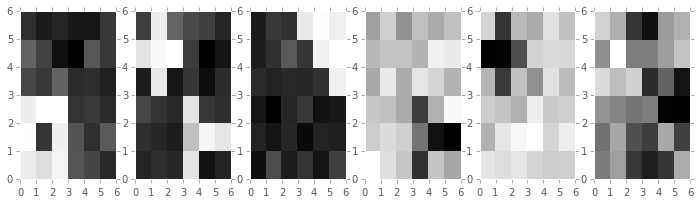

In [29]:
# Setup the array
iteration = 999

Kplus_final = Kplus_arr[iteration] # This works even when Kplus_final is not 4
Z_final = Z_arr[iteration,:,0:Kplus_final].reshape(N,Kplus_final)
sigmaX_final = sigmaX_arr[iteration]
sigmaA_final = sigmaA_arr[iteration]
A_inf = np.dot(np.linalg.inv(np.dot(Z_final.T,Z_final) +  ((sigmaX_final/sigmaA_final)**2)*np.identity(Kplus_final)),np.dot(Z_final.T,X))

# subplot(1,4,1); imagesc(reshape(A_inf(1,:),6,6)); colormap(gray); axis off
# subplot(1,4,2); imagesc(reshape(A_inf(2,:),6,6)); colormap(gray); axis off
# subplot(1,4,3); imagesc(reshape(A_inf(3,:),6,6)); colormap(gray); axis off
# subplot(1,4,4); imagesc(reshape(A_inf(4,:),6,6)); colormap(gray); axis off

# Acceptance rate
print "rA accept:",np.sum(rA_accept)/mcmc
print "rX accept:",np.sum(rX_accept)/mcmc

# print "Example image:\n",A_inf[0,:].reshape(6,6)
plt.figure(num=None,figsize=(12,3),dpi=80)
plt.subplot(161)
plt.pcolormesh(A_inf[0,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(162)
plt.pcolormesh(A_inf[1,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(163)
plt.pcolormesh(A_inf[2,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(164)
plt.pcolormesh(A_inf[3,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(165)
plt.pcolormesh(A_inf[4,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(166)
plt.pcolormesh(A_inf[5,:].reshape(6,6),cmap=plt.cm.gray)

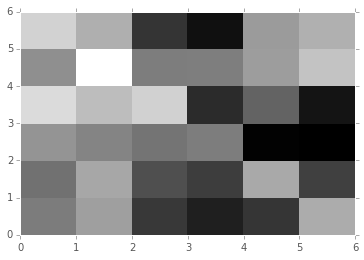

In [25]:
# plt.subplot(155)
plt.pcolormesh(A_inf[5,:].reshape(6,6),cmap=plt.cm.gray)

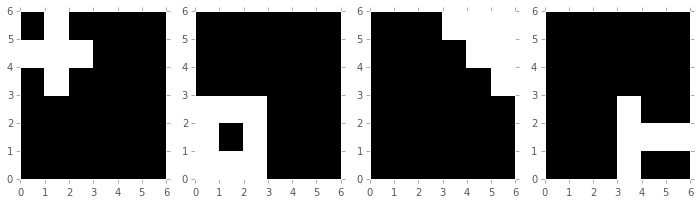

In [16]:
# These are heatmaps!
plt.figure(num=None, figsize=(12,3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(basis1,cmap=plt.cm.gray)     
plt.subplot(142)
plt.pcolormesh(basis2,cmap=plt.cm.gray)  
plt.subplot(143)
plt.pcolormesh(basis3,cmap=plt.cm.gray)  
plt.subplot(144)
plt.pcolormesh(basis4,cmap=plt.cm.gray)  